In [ ]:
import tensorflow as tf

# GPU 사용 가능 여부 확인
if tf.test.gpu_device_name():
  print("GPU 사용 가능")
  #현재 GPU 디바이스 이름 출력
  print("GPU 디바이스 이름:", tf.test.gpu_device_name())
else:
  print("GPU 사용 불가능")

GPU 사용 가능
GPU 디바이스 이름: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -qq "/content/drive/MyDrive/AI_CAR/video.zip"

In [ ]:
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print(f'tf.__version__: {tf.__version__}')

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#imaging
import cv2
import albumentations as A # numpy version 충돌로 인해 imgaug 대신 albumentations 사용
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 2.19.0


image_path: /content/video/train_01067_090.png
steering_Angle: 90


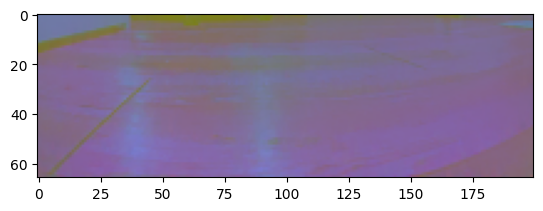

In [ ]:
data_dir = '/content/video'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
  if fnmatch.fnmatch(filename, pattern):
    image_paths.append(os.path.join(data_dir,filename))
    angle = int(filename[-7:-4])
    steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print("steering_Angle: %d" % steering_angles[image_index])
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles


(array([219.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1253.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        819.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <BarContainer object of 25 artists>)

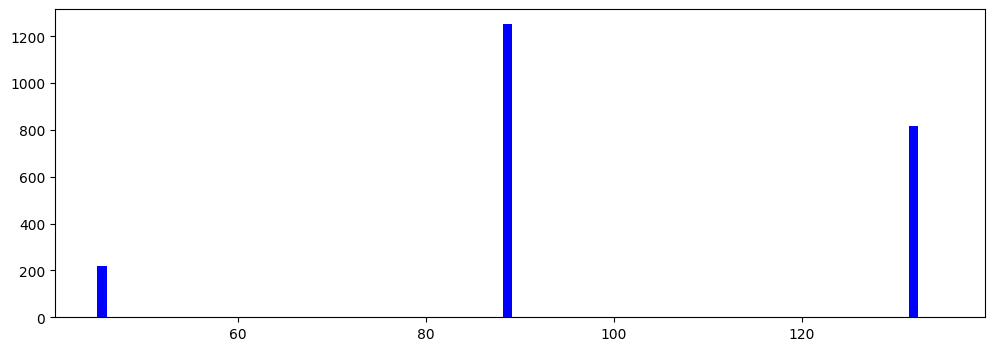

In [ ]:
num_of_bins = 25
hist, bins = np.histogram(df["Angle"], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Training data: 1832
Validation data: 459


Text(0.5, 1.0, 'Validation Data')

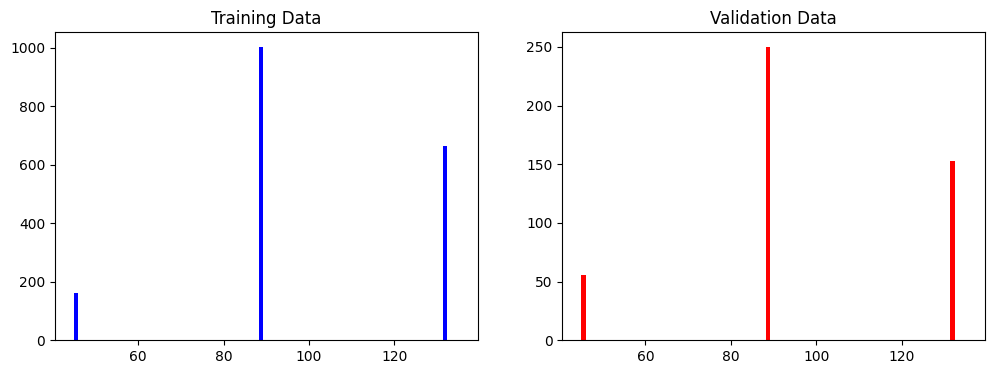

In [ ]:
# 학습데이터(80%)와 검증데이터(20%)를 나눔
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size = 0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

Text(0.5, 1.0, 'processed')

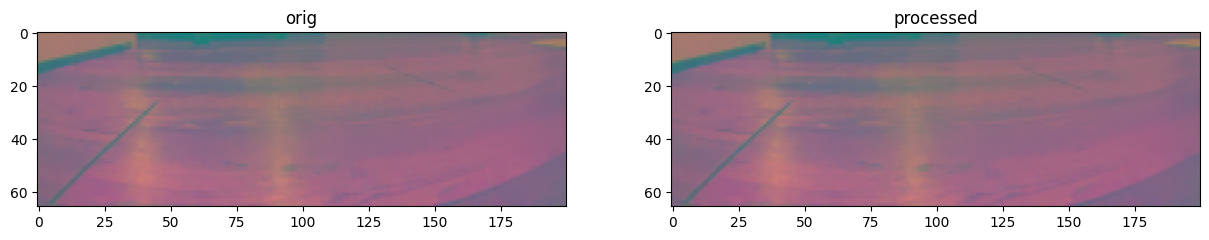

In [ ]:
# opencv 통해 이미지 읽음
def my_imread(image_path):
  image = cv2.imread(image_path)
  return image

# 이미지 정규화(데이터 학습 효과 좋음)
def img_preprocess(image):
  image = image / 255
  return image

# 원본과 정규화된 이미지 비교
fig, axes = plt.subplots(1,2,figsize=(15,10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [ ]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')

    # ELU(Exponential Linear Unit) : x가 음수일 때도 약간의 값을 다음 상태로 넘겨줌
    model.add(Conv2D(24, (5,5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
    model.add(Conv2D(36, (5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, (5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, (3,3), activation='elu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation='elu'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)

    return model

model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 20, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

None


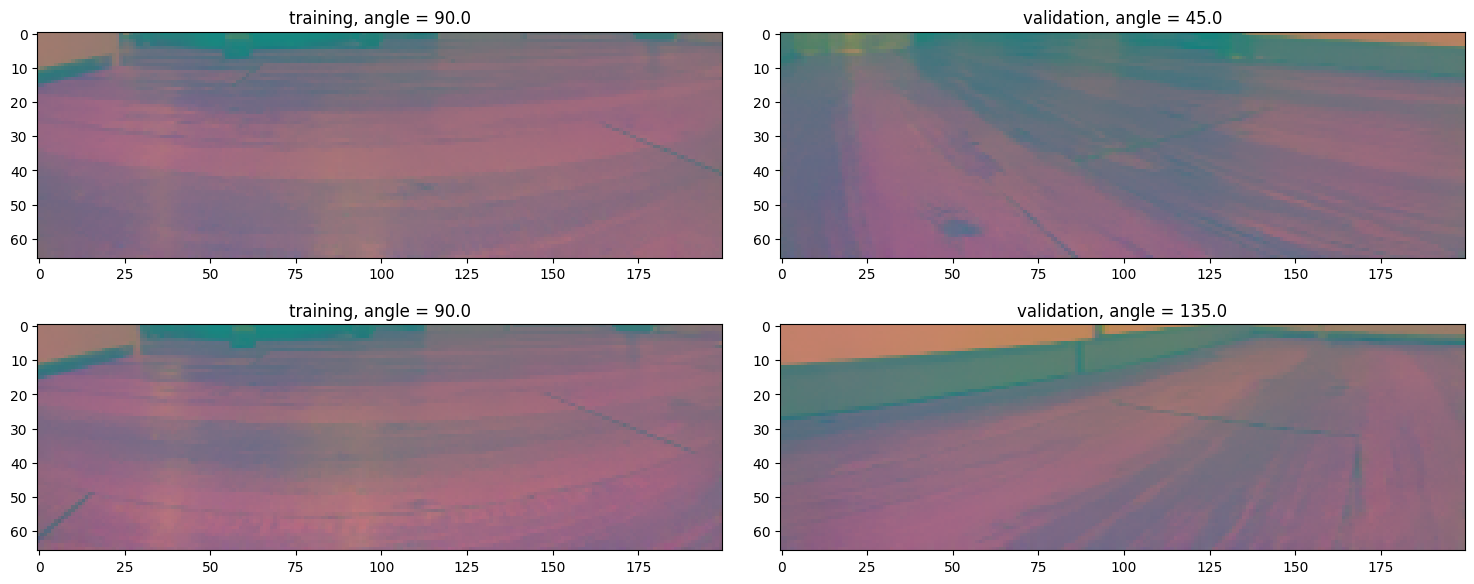

In [ ]:
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]

            image = img_preprocess(image)
            # 모든 이미지 크기 통일
            image = cv2.resize(image, (200, 66))  # W=200, H=66

            batch_images.append(image)
            batch_steering_angles.append(steering_angle)

        # numpy 변환 시 dtype도 맞춰주기
        yield (
            np.array(batch_images, dtype=np.float32),
            np.array(batch_steering_angles, dtype=np.float32)
        )

ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15,6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle = %s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle = %s" % y_valid_batch[i])


In [ ]:
# 모델 학습
model_output_dir = "/content/drive/MyDrive/AI_CAR"

checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath = os.path.join(model_output_dir, 'lane_navigation_Check.h5'), verbose=1, save_best_only=True)
# 원본 이미지에서 100 개의 무작위 이미지 선택하여 학습데이터로 사용
history = model.fit(image_data_generator(X_train, y_train, batch_size = 100),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator(X_valid, y_valid, batch_size = 100),
                              validation_steps = 200,
                              verbose = 1,
                              shuffle = 1,
                              callbacks = [checkpoint_callback]
                              )

model.save(os.path.join(model_output_dir, 'lane_navigation_final.h5'))
history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 15.5484
Epoch 1: val_loss improved from inf to 18.18130, saving model to /content/drive/MyDrive/AI_CAR/lane_navigation_Check.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 126ms/step - loss: 15.5482 - val_loss: 18.1813
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 13.1220
Epoch 2: val_loss improved from 18.18130 to 14.08073, saving model to /content/drive/MyDrive/AI_CAR/lane_navigation_Check.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - loss: 13.1247 - val_loss: 14.0807
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 14.2079
Epoch 3: val_loss improved from 14.08073 to 13.83148, saving model to /content/drive/MyDrive/AI_CAR/lane_navigation_Check.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 14.2064 - val_loss: 13.8315
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 11.9348
Epoch 4: val_loss did not improve from 13.83148
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 11.9348 - val_loss: 16.9155
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 11.7984
Epoch 5: val_loss improved from 13.83148 to 13.30422, saving model to /content/drive/MyDrive/AI_CAR/lane_navigation_Check.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 125ms/step - loss: 11.7968 - val_loss: 13.3042
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 11.0327
Epoch 6: val_loss did not improve from 13.30422
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - loss: 11.0360 - val_loss: 27.6031
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 12.1569
Epoch 7: val_loss did not improve from 13.30422
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - loss: 12.1552 - val_loss: 18.8832
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 10.0369
Epoch 8: val_loss improved from 13.30422 to 11.19718, saving model to /content/drive/MyDrive/AI_CAR/lane_navigation_Check.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 129ms/step - loss: 10.0327 - val_loss: 11.1972
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 9.6699
Epoch 9: val_loss did not improve from 11.19718
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - loss: 9.6675 - val_loss: 12.1176
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 8.6409
Epoch 10: val_loss did not improve from 11.19718
300/300 ━━━━━━━━━━━━━━━━━━━━ 38s 126ms/step - loss: 8.6394 - val_loss: 15.3137


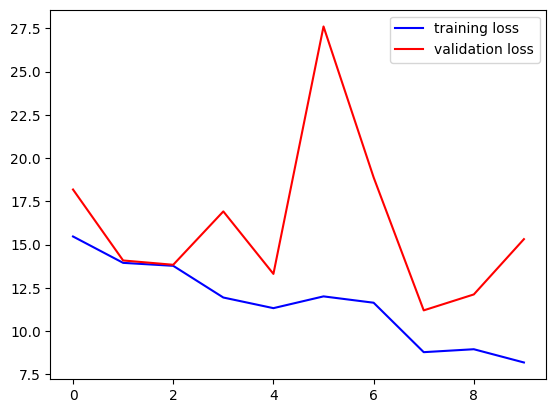

In [ ]:
with open(history_path, 'rb') as f:
    history = pickle.load(f)

plt.plot(history['loss'], color = 'blue')
plt.plot(history['val_loss'], color = 'red')
plt.legend(["training loss", "validation loss"])

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
mse =  9.7
r_squared =  98.79%



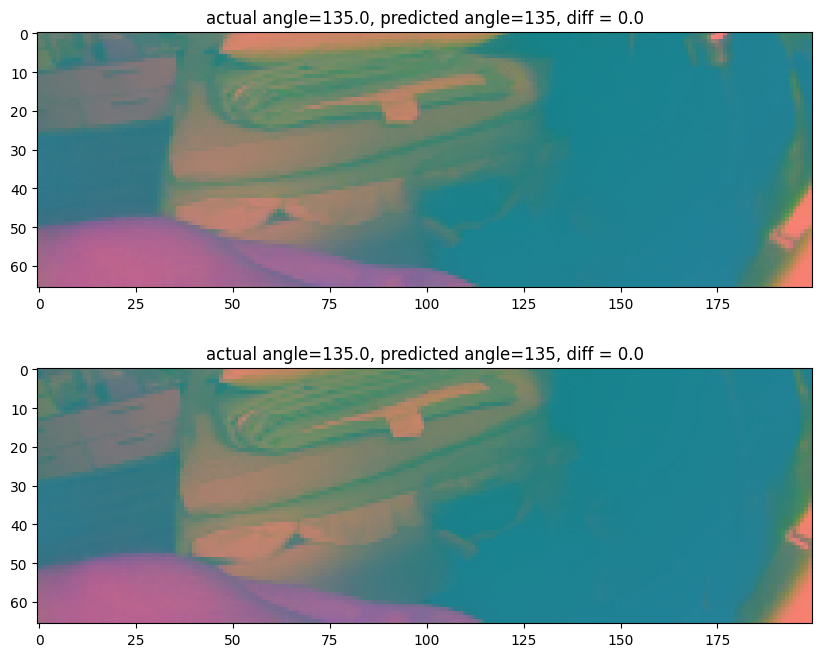

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.losses import MeanSquaredError

def summarize_prediction(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)

# MSE (Mean Squared Error)
# 예측값과 실제값 차이를 제곱한 뒤 평균
# 작을수록 예측이 실제에 가까움

# R² (R-squared, 결정계수)
# 모델이 데이터를 얼마나 잘 설명하는지 비율
#100%에 가까울수록 완벽

    print(f'mse = {mse: .2}')
    print(f'r_squared = {r_squared: .2%}')
    print()

def predict_and_summarize(X,Y):
     # custom_objects로 mse 지정
    model = load_model(
        f'{model_output_dir}/lane_navigation_Check.h5',
        custom_objects={'mse': MeanSquaredError()}
    )
    Y_pred = model.predict(X).flatten()  # shape (batch_size,)
    summarize_prediction(Y, Y_pred)
    return Y_pred

n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show  = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10,4*n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    # diff가 0에 가까울수록 학습이 잘된것